In [4]:
import os
import random
import numpy as np
import json
import pickle
import shutil
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torchvision import transforms
import lovely_tensors as lt
import csng
from csng.utils.mix import RunningStats
from csng.utils.data import crop, normalize
from csng.cat_v1.data import get_cat_v1_dataloaders

lt.monkey_patch()
DATA_PATH = os.path.join(os.environ["DATA_PATH"], "cat_v1_spiking_model", "50K_single_trial_dataset")
print(f"{DATA_PATH=}")

DATA_PATH='/scratch/izar/sobotka/csng/cat_v1_spiking_model/50K_single_trial_dataset'


In [5]:
config = {
    "data": {
        "mixing_strategy": "sequential", # needed only with multiple base dataloaders
    },
    "crop_win": (slice(15, 35), slice(15, 35)),
    "only_v1_data_eval": True,
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "seed": 0,
}

print(f"... Running on {config['device']} ...")
np.random.seed(config["seed"])
torch.manual_seed(config["seed"])
random.seed(config["seed"])

... Running on cuda ...


## Split data

In [6]:
### config
subdirs = ["train", "val"]
train_ratio = 0.9
all_samples = sorted(os.listdir(os.path.join(DATA_PATH, "single_trial")))
total_samples = len(all_samples)
train_samples = int(train_ratio * total_samples)
val_samples = total_samples - train_samples
print(f"{train_samples=}, {val_samples=}")

for subdir in subdirs:
    os.makedirs(os.path.join(DATA_PATH, "datasets", subdir), exist_ok=True)

train_samples=45000, val_samples=5000


In [7]:
### split into subfolders
for sample_idx, sample_name in enumerate(all_samples):
    if sample_idx < train_samples:
        subdir = subdirs[0]
    elif sample_idx < train_samples + val_samples:
        subdir = subdirs[1]
    else:
        subdir = subdirs[2]
    
    ### move file
    stim = np.load(os.path.join(DATA_PATH, "single_trial", sample_name, "stimulus.npy"))
    exc_resp = np.load(os.path.join(DATA_PATH, "single_trial", sample_name, "V1_Exc_L23.npy"))
    inh_resp = np.load(os.path.join(DATA_PATH, "single_trial", sample_name, "V1_Inh_L23.npy"))
    # save as pickle
    with open(os.path.join(DATA_PATH, "datasets", subdir, f"{sample_name}.pickle"), "wb") as f:
        pickle.dump({
            "stim": stim,
            "exc_resp": exc_resp,
            "inh_resp": inh_resp,
        }, f)

### remove previous directory
shutil.rmtree(os.path.join(DATA_PATH, "single_trial"))

## Move and preprocess multi-trial test data

In [8]:
target_dir = os.path.join(DATA_PATH, "datasets", "test")
os.makedirs(target_dir, exist_ok=True)
test_data_path = os.path.join(DATA_PATH, "Dataset_multitrial", "Dic23data", "multitrial")
samples = sorted(os.listdir(test_data_path))
print(f"{len(samples)=},  {target_dir=}")

len(samples)=250,  target_dir='/scratch/izar/sobotka/csng/cat_v1_spiking_model/50K_single_trial_dataset/datasets/test'


In [10]:
### preprocess test multi-trial data and save as pickle
for sample_name in samples:
    sample_dir = os.path.join(test_data_path, sample_name)

    ### move files
    stim = np.load(os.path.join(sample_dir, "stimulus.npy"))
    all_exc_resp = []
    all_inh_resp = []
    for trial_dir_name in os.listdir(sample_dir):
        if trial_dir_name == "stimulus.npy":
            continue
        exc_resp = np.load(os.path.join(sample_dir, trial_dir_name, "V1_Exc_L23.npy"))
        inh_resp = np.load(os.path.join(sample_dir, trial_dir_name, "V1_Inh_L23.npy"))
        all_exc_resp.append(exc_resp)
        all_inh_resp.append(inh_resp)
    exc_resp = np.stack(all_exc_resp, axis=0)
    inh_resp = np.stack(all_inh_resp, axis=0)
    
    ### save as pickle
    with open(os.path.join(target_dir, f"{sample_name}.pickle"), "wb") as f:
        pickle.dump({
            "stim": stim,
            "exc_resp": exc_resp,
            "inh_resp": inh_resp,
        }, f)
    
    ### remove sample_name directory
    shutil.rmtree(sample_dir)

## Get data statistics

In [11]:
config["data"]["cat_v1"] = {
    "train_path": os.path.join(DATA_PATH, "datasets", "train"),
    "val_path": os.path.join(DATA_PATH, "datasets", "val"),
    "test_path": os.path.join(DATA_PATH, "datasets", "test"),
    "image_size": [50, 50],
    "crop": False,
    "batch_size": 1000,
    "stim_keys": ("stim",),
    "resp_keys": ("exc_resp", "inh_resp"),
    # "stim_normalize_mean": 46.143,
    # "stim_normalize_std": 24.960,
    # "resp_normalize_mean": torch.load(
    #     os.path.join(DATA_PATH, "responses_mean.pt")
    # ),
    # "resp_normalize_std": torch.load(
    #     os.path.join(DATA_PATH, "responses_std.pt")
    # ),
}

In [12]:
### images (stimuli)
import torch
from torch.utils.data import DataLoader
from csng.utils.mix import seed_all
from tqdm import tqdm

### load data
seed_all(config["seed"])
v1_dataloaders = get_cat_v1_dataloaders(**config["data"]["cat_v1"])
dataloader = DataLoader(v1_dataloaders["train"].dataset, batch_size=1000, shuffle=False)

### initialize accumulators
n_channels = next(iter(dataloader))[0].size(1)  # get number of channels from first batch
mean_inputs = torch.zeros(n_channels, dtype=torch.float64)
std_inputs = torch.zeros(n_channels, dtype=torch.float64)
n_samples = 0

### single pass for mean
print("[INFO] Computing mean")
seed_all(config["seed"])
dataloader = DataLoader(v1_dataloaders["train"].dataset, batch_size=1000, shuffle=False)
for inputs, _ in tqdm(dataloader):
    batch_size = inputs.size(0)
    n_samples += batch_size
    mean_inputs += inputs.mean(dim=[0, 2, 3]) * batch_size  # sum of per-batch means, weighted by batch size
mean_inputs /= n_samples  # divide by total number of images

### second pass for standard deviation
print("[INFO] Computing std")
variance = torch.zeros(n_channels, dtype=torch.float64)
seed_all(config["seed"])
dataloader = DataLoader(v1_dataloaders["train"].dataset, batch_size=1000, shuffle=False)
for inputs, _ in tqdm(dataloader):
    ### compute squared difference from mean for each pixel
    variance += ((inputs - mean_inputs.view(1, n_channels, 1, 1)) ** 2).mean(dim=[0, 2, 3]) * inputs.size(0)
variance /= n_samples  # divide by total number of images
std_inputs = torch.sqrt(variance)

print(f"Mean: {mean_inputs}")
print(f"Std: {std_inputs}")

### save
torch.save({
    "mean": mean_inputs.to(torch.float32),
    "std": std_inputs.to(torch.float32),
}, os.path.join(DATA_PATH, "stimuli_mean_std.pt"))

[INFO] Computing mean


100%|███████| 45/45 [15:27<00:00, 20.61s/it]


[INFO] Computing std


100%|███████| 45/45 [02:07<00:00,  2.84s/it]


Mean: tensor[1] f64 [46.143]
Std: tensor[1] f64 [24.960]


In [13]:
### responses (per-neurons stats)
import torch
from torch.utils.data import DataLoader
from csng.utils.mix import seed_all
from tqdm import tqdm

### load data
seed_all(config["seed"])
v1_dataloaders = get_cat_v1_dataloaders(**config["data"]["cat_v1"])
dataloader = DataLoader(v1_dataloaders["train"].dataset, batch_size=1000, shuffle=False)

### initialize accumulators
n_neurons = next(iter(dataloader))[1].size(1)  # get number of neurons from first batch
mean_resps = torch.zeros(n_neurons, dtype=torch.float64)
std_resps = torch.zeros(n_neurons, dtype=torch.float64)
n_samples = 0

### single pass for averages
print("[INFO] Computing averages")
seed_all(config["seed"])
dataloader = DataLoader(v1_dataloaders["train"].dataset, batch_size=1000, shuffle=False)
for _, resps in tqdm(dataloader):
    batch_size = resps.size(0)
    n_samples += batch_size
    mean_resps += resps.mean(dim=0) * batch_size  # sum of per-batch means, weighted by batch size
mean_resps /= n_samples  # divide by total number of images

### second pass for standard deviation
print("[INFO] Computing std")
variances = torch.zeros(n_neurons, dtype=torch.float64)
seed_all(config["seed"])
dataloader = DataLoader(v1_dataloaders["train"].dataset, batch_size=1000, shuffle=False)
for _, resps in tqdm(dataloader):
    ### compute squared difference from mean for each pixel
    variances += ((resps - mean_resps.view(1, n_neurons)) ** 2).mean(dim=0) * resps.size(0)
variances /= n_samples  # divide by total number of images
std_resps = torch.sqrt(variances)

print(f"Mean: {mean_resps}")
print(f"Std: {std_resps}")

### save
torch.save({
    "mean": mean_resps.to(torch.float32),
    "std": std_resps.to(torch.float32),
}, os.path.join(DATA_PATH, "responses_mean_std.pt"))
torch.save(mean_resps.to(torch.float32), os.path.join(DATA_PATH, "responses_mean.pt"))
torch.save(std_resps.to(torch.float32), os.path.join(DATA_PATH, "responses_std.pt"))

[INFO] Computing averages


100%|███████| 45/45 [02:11<00:00,  2.92s/it]


[INFO] Computing std


100%|███████| 45/45 [02:22<00:00,  3.16s/it]

Mean: tensor[46875] f64 0.4Mb x∈[0.170, 30.560] μ=3.481 σ=2.709
Std: tensor[46875] f64 0.4Mb x∈[0.619, 18.922] μ=3.424 σ=1.676


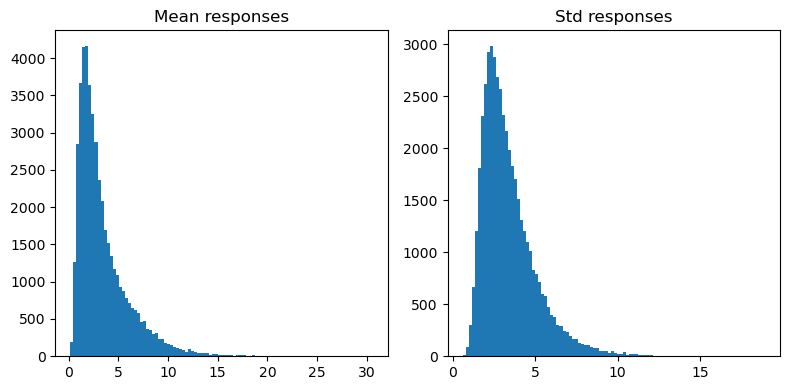

In [14]:
### plot neuron stats
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.hist(mean_resps.numpy(), bins=100)
plt.title("Mean responses")
plt.subplot(122)
plt.hist(std_resps.numpy(), bins=100)
plt.title("Std responses")
plt.tight_layout()
plt.show()